# Stock Price Prediction Using Stacked LSTM

## Libraries

In [36]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [8]:
key = '55fb816765335a53c016881aebe8fb20ee89ef29'
df = pdr.get_data_tiingo('AAPL', api_key = key)

C:\Anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [9]:
df.to_csv('AAPL.csv')

In [10]:
df = pd.read_csv('AAPL.csv')

In [11]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-06-21 00:00:00+00:00,145.87,146.0693,144.6100,145.52,21064679,34.516282,34.563441,34.218136,34.433463,84258716,0.0,1.0
1,AAPL,2017-06-22 00:00:00+00:00,145.63,146.7000,145.1199,145.77,18673365,34.459492,34.712679,34.338790,34.492619,74693460,0.0,1.0
2,AAPL,2017-06-23 00:00:00+00:00,146.28,147.1600,145.1100,145.13,25997976,34.613297,34.821526,34.336448,34.341180,103991904,0.0,1.0
3,AAPL,2017-06-26 00:00:00+00:00,145.82,148.2800,145.3800,147.17,25524661,34.504451,35.086545,34.400336,34.823892,102098644,0.0,1.0
4,AAPL,2017-06-27 00:00:00+00:00,143.73,146.1600,143.6200,145.01,24423643,34.009907,34.584903,33.983879,34.312785,97694572,0.0,1.0


In [13]:
data_close = df.reset_index()['close']
data_close

0       145.87
1       145.63
2       146.28
3       145.82
4       143.73
         ...  
1253    131.88
1254    132.76
1255    135.43
1256    130.06
1257    131.56
Name: close, Length: 1258, dtype: float64

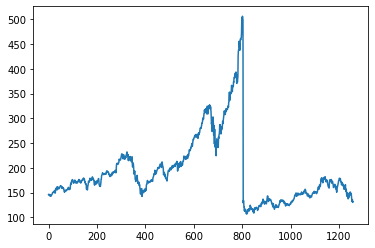

In [15]:
plt.plot(data_close)

In [16]:
# LSTM is sensitive to the scale of the data
# So we apply MinMax scaler -> Values transformed to lie between 0 and 1

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))
data_close.shape

(1258, 1)

In [19]:
data_close

array([[0.0977583 ],
       [0.09715717],
       [0.09878522],
       ...,
       [0.07160927],
       [0.05815905],
       [0.06191609]])

## Train Test Split

Generally we use strategies like `Cross Validation` and `Random seed`.

In case of time-series data, where the data is ordered by date/time, where the next row depends on the previous row. Thus, the order matters. In here the train set and test set are divided sequentially. First x% records become Train set, then test set becomes the remaining (100-x)% records

In [21]:
training_size = int(len(data_close) * 0.65) # First 65%
test_size = len(data_close) - training_size # Remaining 35%

train_data, test_data = data_close[:training_size,:], data_close[training_size:len(data_close), :]

In [22]:
training_size, test_size

(817, 441)

## Data preprocessing

Considering timesteps, how many past days we need to consider to predict the value for next date

If training data looks as follows:
- 120, 130, 125, 140, 134, 150

Timesteps = 3

<- X-train -> Y-train
f1   f2   f3   o/p
120  130  125  140
130  125  140  134

If test data looks as follows:
- 160, 190, 154, 160, 170

<- X-test ->  Y-test
f1   f2   f3   o/p
160  190  154  160
190  154  160  170

We will train the lstm model using the training data, then we will try to predict over x-test using trained model. And then we will compare the predictions against y-test as calculated above, that will help us analyse how are model is performing.

In [23]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i: (i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [25]:
X_train.shape, y_train.shape

((716, 100), (716,))

In [26]:
X_test.shape, y_test.shape

((340, 100), (340,))

In [28]:
# Reshape X_train and X_test to 3-D, which would be accepted by the LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model Initialisation

In [32]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Training

In [34]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 13s 444ms/step - loss: 0.0475 - val_loss: 0.0046
Epoch 2/100
12/12 [==============================] - 3s 257ms/step - loss: 0.0148 - val_loss: 0.0090
Epoch 3/100
12/12 [==============================] - 3s 248ms/step - loss: 0.0113 - val_loss: 5.5110e-04
Epoch 4/100
12/12 [==============================] - 3s 249ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 5/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0090 - val_loss: 0.0012
Epoch 6/100
12/12 [==============================] - 3s 271ms/step - loss: 0.0085 - val_loss: 3.6001e-04
Epoch 7/100
12/12 [==============================] - 3s 262ms/step - loss: 0.0077 - val_loss: 0.0012
Epoch 8/100
12/12 [==============================] - 3s 235ms/step - loss: 0.0073 - val_loss: 4.1629e-04
Epoch 9/100
12/12 [==============================] - 3s 238ms/step - loss: 0.0069 - val_loss: 3.4846e-04
Epoch 10/100
12/12 [==============================] - 3s 256ms/step - loss

12/12 [==============================] - 3s 243ms/step - loss: 0.0013 - val_loss: 1.6382e-04
Epoch 79/100
12/12 [==============================] - 3s 235ms/step - loss: 0.0013 - val_loss: 1.8625e-04
Epoch 80/100
12/12 [==============================] - 3s 252ms/step - loss: 0.0012 - val_loss: 1.5839e-04
Epoch 81/100
12/12 [==============================] - 3s 234ms/step - loss: 0.0012 - val_loss: 1.6070e-04
Epoch 82/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0013 - val_loss: 1.6916e-04
Epoch 83/100
12/12 [==============================] - 3s 229ms/step - loss: 0.0012 - val_loss: 2.3113e-04
Epoch 84/100
12/12 [==============================] - 3s 243ms/step - loss: 0.0012 - val_loss: 1.6559e-04
Epoch 85/100
12/12 [==============================] - 3s 244ms/step - loss: 0.0011 - val_loss: 2.7094e-04
Epoch 86/100
12/12 [==============================] - 3s 261ms/step - loss: 0.0011 - val_loss: 1.7208e-04
Epoch 87/100
12/12 [==============================] - 3s 23

## Prediction

In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 1s 45ms/step


In [38]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

## Metrics

In [39]:
# Calculating RMSE
math.sqrt(mean_squared_error(y_train, train_predict))

240.41343735438386

In [40]:
math.sqrt(mean_squared_error(y_test, test_predict))

151.84672204371753

## Visualization

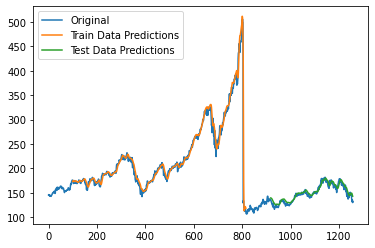

In [43]:
look_back = 100
trainPredictPlot = np.empty_like(data_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1: len(data_close) - 1, :] = test_predict

plt.plot(scaler.inverse_transform(data_close)) # Scaling up the values to the actual scale
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original', 'Train Data Predictions', 'Test Data Predictions'])
plt.show()

## Predicting future 30 days